<a href="https://colab.research.google.com/github/alfawzaan/deep-learning-projects/blob/master/Planta_Crop_Disease_Classification_(MLPs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np  

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import PIL
print(PIL.PILLOW_VERSION)


6.2.2


In [0]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163229, done.
remote: Total 163229 (delta 0), reused 0 (delta 0), pack-reused 163229
Receiving objects: 100% (163229/163229), 2.00 GiB | 43.71 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Checking out files: 100% (182401/182401), done.


In [0]:
import random
import os
from shutil import copy


#TODO: Create DIR for validation


dataset_dir = '/content/PlantVillage-Dataset/raw/color/'

def build_dataset():
    """
    Split original dataset into train and test sets.
    """

    for subdir, dirs, files in os.walk(dataset_dir):
        file_paths = []
        folder_name = os.path.basename(subdir)

        for file in files:
            file_paths.append(os.path.join(subdir, file))

        if len(file_paths) > 0:
            file_paths.sort()  # make sure that the file_paths have a fixed order before shuffling
            random.seed(230)
            random.shuffle(file_paths)

            boundary = int(0.8 * len(file_paths))
            train = file_paths[:boundary]
            test = file_paths[boundary:]

            # create folders
            if not os.path.exists(os.path.join('/content/dataset/train', folder_name)):
                os.makedirs(os.path.join('/content/dataset/train', folder_name))

            if not os.path.exists(os.path.join('/content/dataset/test', folder_name)):
                os.makedirs(os.path.join('/content/dataset/test', folder_name))

            # copy images in created folders
            for path in train:
                copy(path, os.path.join('/content/dataset/train', folder_name))

            for path in test:
                copy(path, os.path.join('/content/dataset/test', folder_name))

    print("Done building dataset")

build_dataset()    


Done building dataset


In [0]:
# Load data
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# Transforms for the training data and testing data
train_transforms = transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Pass transforms in here, then run the next cell to see how the transforms look
data_dir = '/content/dataset'
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)



# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = train_data.classes
print(classes)
print(len(classes))



['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

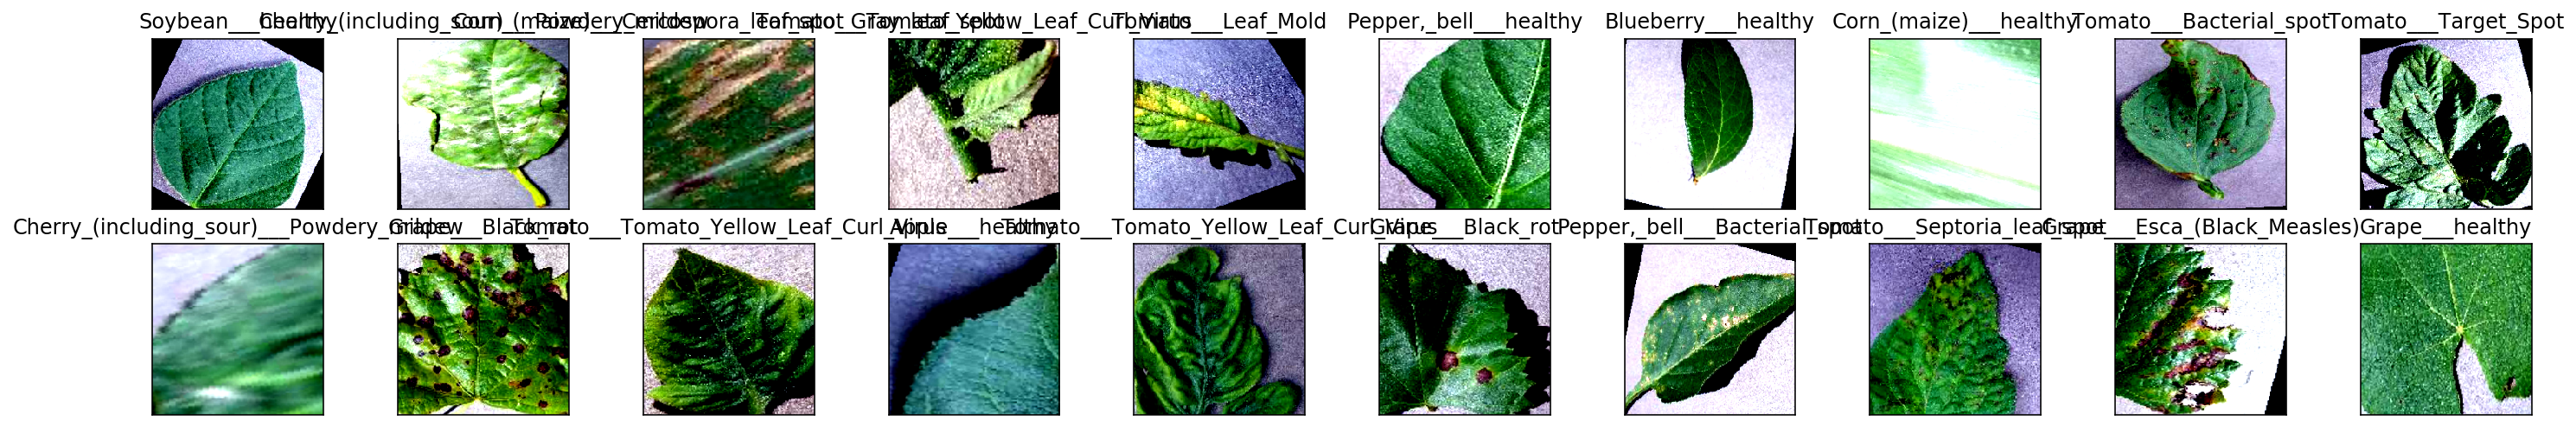

In [0]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
# Use GPU if it's available
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('Bummer!  Training on CPU ...')
else:
    print('You are good to go!  Training on GPU ...')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Build and train your network
model = models.resnet152(pretrained=True)

You are good to go!  Training on GPU ...
cuda:0


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:05<00:00, 41.3MB/s]


In [0]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict

# input_size matches the in_features of pretrained model i.e resnet152

model.fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(512, 38)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
epochs = 30

training_steps = 0
validation_steps = 0

trianing_steps = 0
trainig_print_every = 100

validation_steps = 0
validation_print_every = 100


# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(epochs):
  # monitor training loss
  running_loss = 0.0
  valid_loss = 0.0
    
  ###################
  # train the model #
  ###################
  model.train() # prep model for training
  for inputs, labels in train_loader:
        training_steps += 1
        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()


        logits = model.forward(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*inputs.size(0)

        if training_steps % trainig_print_every == 0:
          print("Training step: {} \tRunning Loss: {:.6f}".format(training_steps, (running_loss/len(train_loader.sampler))))

  # calculate and print avg train loss
  running_loss = running_loss/len(train_loader.sampler)
  print('Running Loss: {:.6f}\n'.format(running_loss))

  ######################    
  # validate the model #
  ######################
  model.eval() # prep model for evaluation
  for data, target in valid_loader:
        validation_steps += 1
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)

        if validation_steps % validation_print_every == 0:
          print("Validation step: {} \tRunning Loss: {:.6f}".format(validation_steps, (valid__loss/len(valid_loader.sampler))))
        
  # print training/validation statistics 
  # calculate average loss over an epoch
  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)
    
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'planta_model.pt')
        valid_loss_min = valid_loss

    

Training step: 100 	Running Loss: 0.037509
Training step: 200 	Running Loss: 0.072571
Training step: 300 	Running Loss: 0.110319
Training step: 400 	Running Loss: 0.147467
Training step: 500 	Running Loss: 0.184523
Training step: 600 	Running Loss: 0.221010
Training step: 700 	Running Loss: 0.256907
Training step: 800 	Running Loss: 0.290029
Training step: 900 	Running Loss: 0.324170
Training step: 1000 	Running Loss: 0.359285


In [0]:

model.load_state_dict(torch.load('planta_model.pt'))

In [0]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(39))
class_total = list(0. for i in range(39))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))